In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
from qiskit_optimization import QuadraticProgram

# Creating synthetic data for P2P energy training

In [47]:
samples = np.random.normal(loc=11.5, scale=4.7, size=15000)

hours = np.arange(24)
min_value = 10
max_value = 123

participants_dict_per_hourdict={}
for hour in hours:
    participants_dict_per_hourdict[f"{hour}"] = 0
    for sample in samples:
        if np.abs(sample - hour)<.5:
              participants_dict_per_hourdict[f"{hour}"]+=1 
participants_by_hour = np.asarray(list(participants_dict_per_hourdict.values()))
participants_by_hour = participants_by_hour/np.max(participants_by_hour) * max_value

#either we set the values below min_value to min_value or throw it a away
#participants_by_hour[participants_by_hour<min_value] = 0
#participants_by_hour = np.clip(participants_by_hour/np.max(participants_by_hour) * max_value, a_min=min_value, a_max=max_value)

columns = ['Hour', 'Participant', 'Type', 'Price (cents/KWh)', 'Quantity (KW)']
df = pd.DataFrame(columns=columns)

# Generate bids and asks for each hour
for hour in hours:
    #print(hour)
    participants_by_hour[hour]=int(participants_by_hour[hour])
    if participants_by_hour[hour]%2!=0:
        participants_by_hour[hour]-=1
    print(f"hour:{hour}",participants_by_hour[hour])
    num_prosumers = int(participants_by_hour[hour]/2)
    num_consumers = int(participants_by_hour[hour] - num_prosumers)


    if participants_by_hour[hour] > 0:
    # Generate prosumer bids
        prosumer_bids = pd.DataFrame({
            'Hour': hour,
            'Participant': np.arange(num_prosumers),
            'Type': 'Bid',
            'Price (cents/KWh)': np.random.randint(8, 33, size=num_prosumers),
            'Quantity (KW)': np.random.randint(1, 6, size=num_prosumers)
        })

    # Generate consumer asks
        consumer_asks = pd.DataFrame({
            'Hour': hour,
            'Participant': np.arange(num_prosumers, num_prosumers + num_consumers),
            'Type': 'Ask',
            'Price (cents/KWh)': np.random.randint(8, 33, size=num_consumers),
            'Quantity (KW)': np.random.randint(5, 11, size=num_consumers)
        })
    else:
        # Generate prosumer bids
        prosumer_bids = pd.DataFrame({
            'Hour': hour,
            'Participant': [None],
            'Type': 'Bid',
            'Price (cents/KWh)': 0,
            'Quantity (KW)': 0
        })

    # Generate consumer asks
        consumer_asks = pd.DataFrame({
            'Hour': hour,
            'Participant': [None],
            'Type': 'Ask',
            'Price (cents/KWh)': 0,
            'Quantity (KW)': 0
        })
    

    # Concatenate prosumer bids and consumer asks
    hour_data = pd.concat([prosumer_bids, consumer_asks], ignore_index=True)

    # Add the generated data to the main DataFrame
    df = pd.concat([df, hour_data], ignore_index=True)

    df["Participant"]
# Sort the DataFrame based on hour and participant
df.sort_values(by=['Hour', 'Participant'], inplace=True, ignore_index=True)

hour:0 6.0
hour:1 8.0
hour:2 16.0
hour:3 22.0
hour:4 36.0
hour:5 46.0
hour:6 62.0
hour:7 78.0
hour:8 96.0
hour:9 108.0
hour:10 122.0
hour:11 120.0
hour:12 122.0
hour:13 122.0
hour:14 112.0
hour:15 94.0
hour:16 74.0
hour:17 58.0
hour:18 50.0
hour:19 34.0
hour:20 22.0
hour:21 18.0
hour:22 8.0
hour:23 6.0


In [48]:
df[df["Hour"]==0]

,Hour,Participant,Type,Price (cents/KWh),Quantity (KW)
0,0,0,Bid,28,1
1,0,1,Bid,31,1
2,0,2,Bid,25,4
3,0,3,Ask,17,6
4,0,4,Ask,26,7
5,0,5,Ask,20,9


In [49]:
df_length_per_hour = df.groupby('Hour').size()

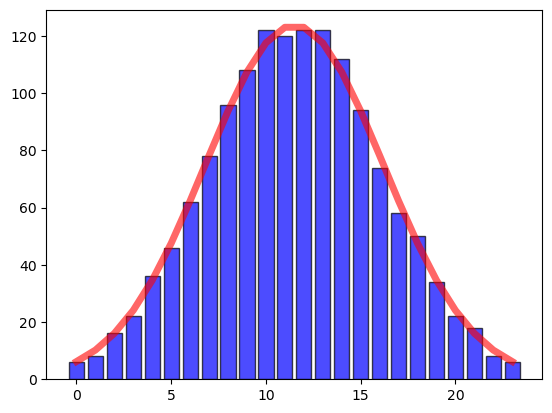

In [50]:
#comparing to exact distribution
#also cutting the cases when participants are below 10
x = np.linspace(0,23,24)

df_length_per_hour = df.groupby('Hour').size()
#df_length_per_hour[df_length_per_hour<10] = 0
plt.bar(df_length_per_hour.index, df_length_per_hour.values, color='blue', alpha=0.7,edgecolor='black')
plt.plot(hours,123* norm.pdf(x, loc = 11.5, scale = 4.7)/max(norm.pdf(x, loc = 11.5, scale = 4.7)),
       'r-', lw=5, alpha=0.6, label='norm pdf')

# Creating QUBO

The cost function in the original formulation

$\max\limits_{x_{ij}} \sum\limits_{i=1}^{C}\sum\limits_{j=1}^{P} x_{ij}(p_i-p_j){\text{min}}\{Q_i,Q_j\}$

Subject to

$\sum\limits_{i}^C x_{ij}{\text{min}}\{Q_i,Q_j\}\leq Q_j$


$\sum\limits_{j}^P x_{ij}{\text{min}}\{Q_i,Q_j\}\leq Q_i$

In [58]:
#creating the Quadratic program
mod = QuadraticProgram("ET")
print(mod.prettyprint())

Problem name: ET

Minimize
  0

Subject to
  No constraints

  No variables



As of yet we are going to fill this up with the bids and asks from a given time interval, e.g. 2.

In [59]:
df[df["Hour"]==0]

,Hour,Participant,Type,Price (cents/KWh),Quantity (KW)
0,0,0,Bid,28,1
1,0,1,Bid,31,1
2,0,2,Bid,25,4
3,0,3,Ask,17,6
4,0,4,Ask,26,7
5,0,5,Ask,20,9


In [60]:
hour = 0

for i in range(int(len(df[df["Hour"]==hour])/2)): #consumers
    for j in range(int(len(df[df["Hour"]==hour])/2),int(len(df[df["Hour"]==hour]))): #prosumers
        mod.binary_var(name=f"x_{int(i)}_{int(j)}")
print(mod.prettyprint())

Problem name: ET

Minimize
  0

Subject to
  No constraints

  Binary variables (9)
    x_0_3 x_0_4 x_0_5 x_1_3 x_1_4 x_1_5 x_2_3 x_2_4 x_2_5



Now we assign the cost function given above.

In [61]:
#creating the cost function
#cost
lind_dict={}

for i in range(int(len(df[df["Hour"]==hour])/2)): #consumers
    for j in range(int(len(df[df["Hour"]==hour])/2),int(len(df[df["Hour"]==hour]))):
        lind_dict[f"x_{int(i)}_{int(j)}"]=df.loc[df["Hour"] == hour, "Price (cents/KWh)"].values[i]-df.loc[df["Hour"] == hour, "Price (cents/KWh)"].values[j]\
            *min(df.loc[df["Hour"] == 2, "Quantity (KW)"].values[i],df.loc[df["Hour"] == 2, "Quantity (KW)"].values[j])


In [62]:
lind_dict

{'x_0_3': -6,
 'x_0_4': 2,
 'x_0_5': -32,
 'x_1_3': 14,
 'x_1_4': 5,
 'x_1_5': 11,
 'x_2_3': -9,
 'x_2_4': -1,
 'x_2_5': -55}

In [63]:
mod.maximize(linear=lind_dict)
print(mod.prettyprint())

Problem name: ET

Maximize
  -6*x_0_3 + 2*x_0_4 - 32*x_0_5 + 14*x_1_3 + 5*x_1_4 + 11*x_1_5 - 9*x_2_3
  - x_2_4 - 55*x_2_5

Subject to
  No constraints

  Binary variables (9)
    x_0_3 x_0_4 x_0_5 x_1_3 x_1_4 x_1_5 x_2_3 x_2_4 x_2_5



We create the constraints given above.

In [64]:
#constraint consumers
constraints_consumer={}
for i in range(int(len(df[df["Hour"]==hour])/2)):
    constraints_consumer[f"consumer_ID_{i}"] = {}
    for j in range(int(len(df[df["Hour"]==hour])/2),int(len(df[df["Hour"]==hour]))):
        constraints_consumer[f"consumer_ID_{i}"][f"x_{i}_{j}"] = min(df.loc[df["Hour"] == hour, "Quantity (KW)"].values[i],df.loc[df["Hour"] == hour, "Quantity (KW)"].values[j])

#constraint prosumers
constraints_prosumer={}
for j in range(int(len(df[df["Hour"]==hour])/2),int(len(df[df["Hour"]==hour]))):
    constraints_prosumer[f"prosumer_ID_{j}"] = {}
    for i in range(int(len(df[df["Hour"]==hour])/2)):
        constraints_prosumer[f"prosumer_ID_{j}"][f"x_{i}_{j}"] = min(df.loc[df["Hour"] == hour, "Quantity (KW)"].values[i],df.loc[df["Hour"] == hour, "Quantity (KW)"].values[j])


In [65]:
#this is a dictinary
constraints_consumer

{'consumer_ID_0': {'x_0_3': 1, 'x_0_4': 1, 'x_0_5': 1},
 'consumer_ID_1': {'x_1_3': 1, 'x_1_4': 1, 'x_1_5': 1},
 'consumer_ID_2': {'x_2_3': 4, 'x_2_4': 4, 'x_2_5': 4}}

In [67]:
#adding consumer_constraints
for i in range(int(len(df[df["Hour"]==hour])/2)):
    mod.linear_constraint(linear=constraints_consumer[f"consumer_ID_{i}"], sense="<=", rhs=df.loc[df["Hour"] == hour, "Quantity (KW)"].values[i], name=f"cons_constraint_{i}")

#adding prosumer_constraints
for j in range(int(len(df[df["Hour"]==hour])/2),int(len(df[df["Hour"]==hour]))):
    mod.linear_constraint(linear=constraints_prosumer[f"prosumer_ID_{j}"], sense="<=", rhs=df.loc[df["Hour"] == hour, "Quantity (KW)"].values[j], name=f"pros_constraint_{j}")

QiskitOptimizationError: "Linear constraint's name already exists: cons_constraint_0"

In [68]:
print(mod.prettyprint())

Problem name: ET

Maximize
  -6*x_0_3 + 2*x_0_4 - 32*x_0_5 + 14*x_1_3 + 5*x_1_4 + 11*x_1_5 - 9*x_2_3
  - x_2_4 - 55*x_2_5

Subject to
  Linear constraints (3)
    x_0_3 + x_0_4 + x_0_5 <= 3  'cons_constraint_0'
    x_1_3 + x_1_4 + x_1_5 <= 1  'cons_constraint_1'
    4*x_2_3 + 4*x_2_4 + 4*x_2_5 <= 5  'cons_constraint_2'

  Binary variables (9)
    x_0_3 x_0_4 x_0_5 x_1_3 x_1_4 x_1_5 x_2_3 x_2_4 x_2_5



Let's convert the program to QUBO

In [69]:
from qiskit_optimization.converters import QuadraticProgramToQubo

conv = QuadraticProgramToQubo()
mod_qubo = conv.convert(mod)

In [70]:
print(mod_qubo.prettyprint())

Problem name: ET

Minimize
  544*cons_constraint_0@int_slack@0^2
  + 2176*cons_constraint_0@int_slack@0*cons_constraint_0@int_slack@1
  + 2176*cons_constraint_0@int_slack@1^2 + 544*cons_constraint_2@int_slack@0^2
  + 2176*cons_constraint_2@int_slack@0*cons_constraint_2@int_slack@1
  + 2176*cons_constraint_2@int_slack@0*cons_constraint_2@int_slack@2
  + 2176*cons_constraint_2@int_slack@1^2
  + 4352*cons_constraint_2@int_slack@1*cons_constraint_2@int_slack@2
  + 2176*cons_constraint_2@int_slack@2^2
  + 1088*x_0_3*cons_constraint_0@int_slack@0
  + 2176*x_0_3*cons_constraint_0@int_slack@1 + 544*x_0_3^2 + 1088*x_0_3*x_0_4
  + 1088*x_0_3*x_0_5 + 1088*x_0_4*cons_constraint_0@int_slack@0
  + 2176*x_0_4*cons_constraint_0@int_slack@1 + 544*x_0_4^2 + 1088*x_0_4*x_0_5
  + 1088*x_0_5*cons_constraint_0@int_slack@0
  + 2176*x_0_5*cons_constraint_0@int_slack@1 + 544*x_0_5^2 + 136*x_1_3*x_1_4
  + 136*x_1_3*x_1_5 + 136*x_1_4*x_1_5 + 4352*x_2_3*cons_constraint_2@int_slack@0
  + 8704*x_2_3*cons_constraint

The QUBO matrix has the following form.

In [71]:
A_tilde = mod_qubo.objective.quadratic.to_array()
print(f"Dimension: {A_tilde.shape}")

Dimension: (14, 14)


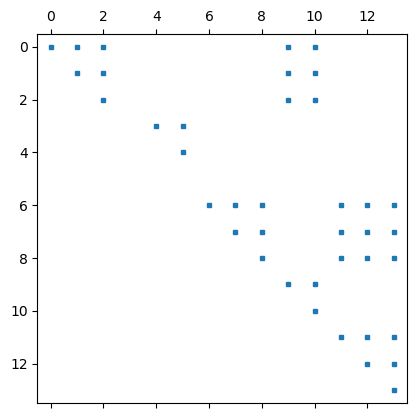

In [72]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.spy(A_tilde, markersize=3)

In [73]:
from qiskit_optimization.algorithms import CplexOptimizer

In [74]:
cplex_optimizer = CplexOptimizer()
qubo_minimization_result = cplex_optimizer.solve(mod_qubo)

In [75]:
print("minimum point (binary): b_min = ", qubo_minimization_result.x)
print("minimum value: f_3(b_min) = ", qubo_minimization_result.fval)

minimum point (binary): b_min =  [0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1.]
minimum value: f_3(b_min) =  -16.0


In [76]:
b_min = qubo_minimization_result.x
p_min = conv.interpret(b_min)
print("minimum point (integer): p_min = ", p_min)

minimum point (integer): p_min =  [0. 1. 0. 1. 0. 0. 0. 0. 0.]
